In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

from PIL import Image
import glob
import cv2
import random

%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D

Using TensorFlow backend.


## Load Data

In [2]:
# Load Udacity's data - images are in IMG_udacity
df = pd.read_csv('driving_log_udacity.csv', header=0)
df.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]
len(df)

8036

In [3]:
# Load Generate Recovery Data - images are in IMG_recovery
df_recovery = pd.read_csv('driving_log_recovery.csv', header=0)
df_recovery.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]
len(df_recovery)

1347

In [4]:
df[0:3]

center_image  \
0  IMG_udacity/center_2016_12_01_13_30_48_287.jpg   
1  IMG_udacity/center_2016_12_01_13_30_48_404.jpg   
2  IMG_udacity/center_2016_12_01_13_31_12_937.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_30_48_287.jpg   
1   IMG_udacity/left_2016_12_01_13_30_48_404.jpg   
2   IMG_udacity/left_2016_12_01_13_31_12_937.jpg   

                                      right_image  steering_angle  throttle  \
0   IMG_udacity/right_2016_12_01_13_30_48_287.jpg             0.0       0.0   
1   IMG_udacity/right_2016_12_01_13_30_48_404.jpg             0.0       0.0   
2   IMG_udacity/right_2016_12_01_13_31_12_937.jpg             0.0       0.0   

   break      speed  
0    0.0  22.148290  
1    0.0  21.879630  
2    0.0   1.453011

In [5]:
df_recovery[0:3]

center_image  \
0  IMG_recovery/center_2017_01_06_13_54_47_000.jpg   
1  IMG_recovery/center_2017_01_06_13_54_47_110.jpg   
2  IMG_recovery/center_2017_01_06_13_54_47_212.jpg   

                                       left_image  \
0   IMG_recovery/left_2017_01_06_13_54_47_000.jpg   
1   IMG_recovery/left_2017_01_06_13_54_47_110.jpg   
2   IMG_recovery/left_2017_01_06_13_54_47_212.jpg   

                                       right_image  steering_angle  throttle  \
0   IMG_recovery/right_2017_01_06_13_54_47_000.jpg             0.0       0.0   
1   IMG_recovery/right_2017_01_06_13_54_47_110.jpg             0.0       0.0   
2   IMG_recovery/right_2017_01_06_13_54_47_212.jpg             0.0       0.0   

   break     speed  
0    0.0  0.000058  
1    0.0  0.000056  
2    0.0  0.000056

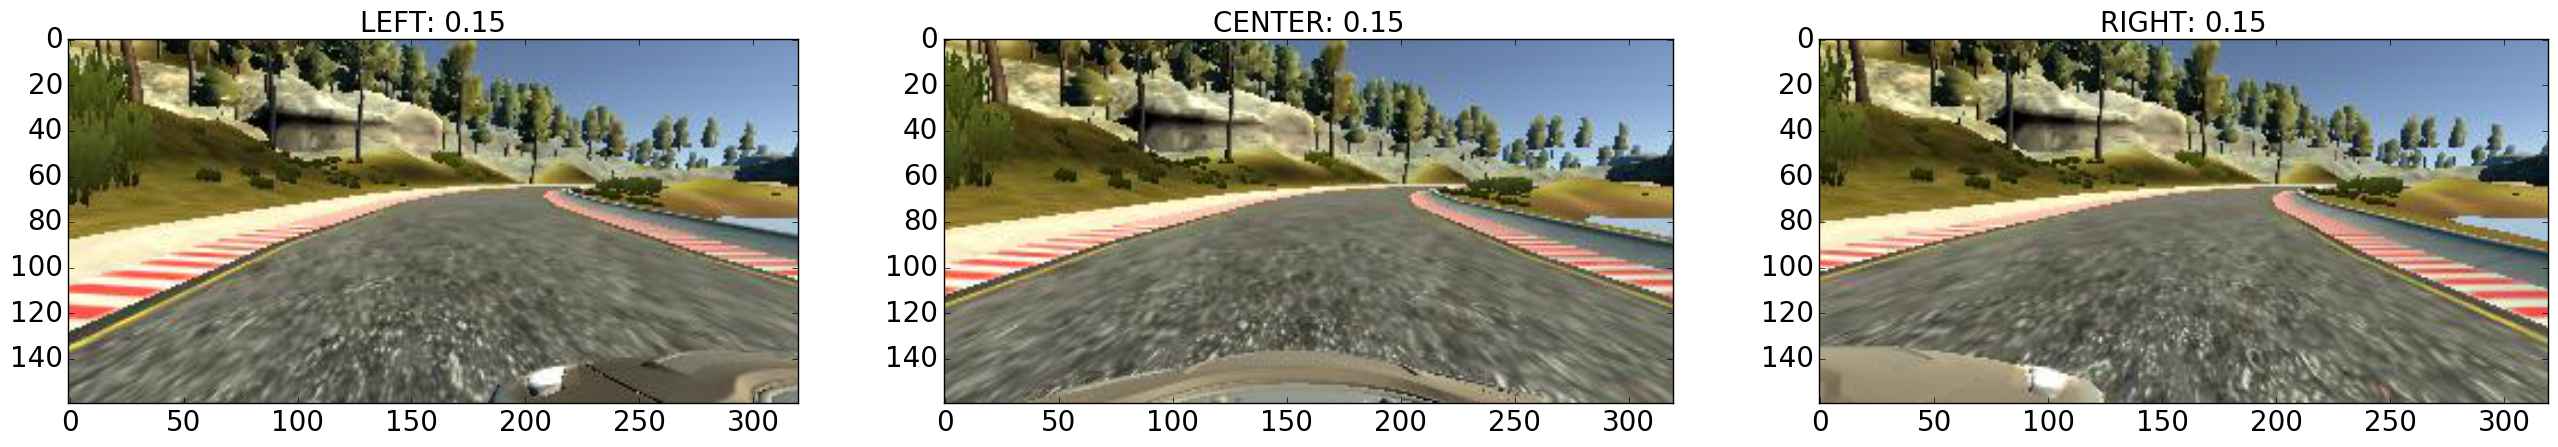

In [6]:
# Visualize left, center and right angle camera at the same moment
chk_idx = 275
img_left = mpimg.imread(df["left_image"][chk_idx].strip())
img_center = mpimg.imread(df["center_image"][chk_idx].strip())
img_right = mpimg.imread(df["right_image"][chk_idx].strip())
angle = df["steering_angle"][chk_idx]

# Keeping the 640 x 480 perspective 
plt.rcParams["figure.figsize"] = [32, 24]
plt.tick_params(axis='x', labelsize=25)

plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title("LEFT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 2)
plt.imshow(img_center)
plt.title("CENTER: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title("RIGHT: " + str(np.round(angle, 2)), fontsize=20)
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

#plt.tight_layout()
plt.show()

In [7]:
for i in range(3):
    print (i, '{:}'.format(df["center_image"][i]))

0 IMG_udacity/center_2016_12_01_13_30_48_287.jpg
1 IMG_udacity/center_2016_12_01_13_30_48_404.jpg
2 IMG_udacity/center_2016_12_01_13_31_12_937.jpg


In [8]:
print('{:}'.format(df_recovery.loc[100]["center_image"]))

IMG_recovery/center_2017_01_06_13_55_11_035.jpg


In [9]:
# This is a 160 pixel x 320 pixel x 3 channels
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNEL = img_center.shape
print("img_height:", IMG_HEIGHT)
print("img_width:", IMG_WIDTH)
print("img_channel:", IMG_CHANNEL)

img_height: 160
img_width: 320
img_channel: 3


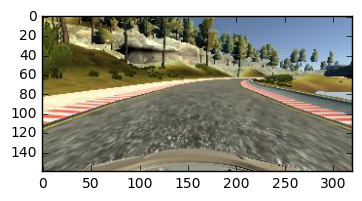

In [10]:
plt.figure(figsize=(4, 3))
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=10)
plt.imshow(img_center)

In [11]:
min_angle = np.min(df["steering_angle"])
max_angle = np.max(df["steering_angle"])
print(min_angle, max_angle)

-0.9426954 1.0


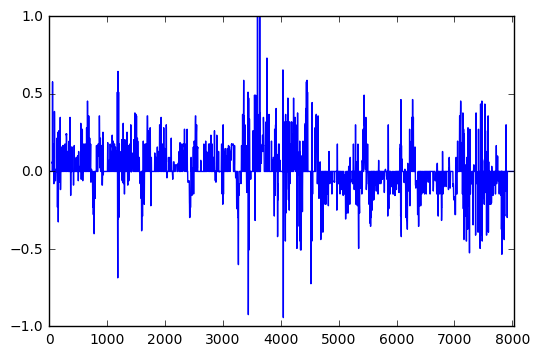

In [12]:
# Time Series plot of steering angles
plt.figure(figsize=(6, 4))
ts = df["steering_angle"]
ts.plot()

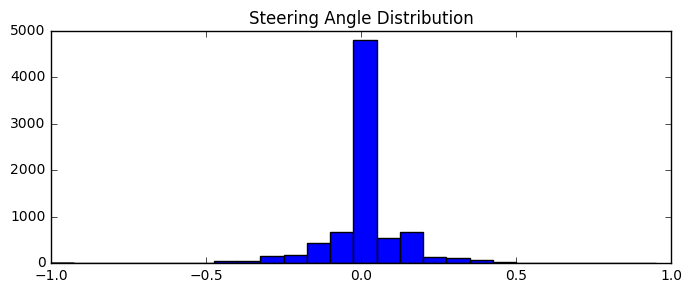

In [13]:
plt.figure(figsize=(8,3))
plt.hist(ts.astype('float'), bins=np.arange(-1.0, 1.0, 0.075))
plt.title("Steering Angle Distribution")
plt.show()

In [14]:
bins = np.arange(-1.0, 1.0, 0.075)
hist, bin_edges = np.histogram(df["steering_angle"], bins=bins)
print (bins)
print (hist)

[-1.    -0.925 -0.85  -0.775 -0.7   -0.625 -0.55  -0.475 -0.4   -0.325
 -0.25  -0.175 -0.1   -0.025  0.05   0.125  0.2    0.275  0.35   0.425  0.5
  0.575  0.65   0.725  0.8    0.875  0.95 ]
[   3    1    1    2    4    2   18   55   55  163  184  449  679 4797  555
  673  139  123   81   32    6   10    1    1    0    0]


In [15]:
# Create Steering Angle Bin Counts  
steer_bin = []

for i in range(len(hist)):
    steer_bin.append([bins[i], bins[i+1], hist[i]])
    
# Examine Steering Angle Bin Counts
steer_bin

[[-1.0, -0.92500000000000004, 3],
 [-0.92500000000000004, -0.85000000000000009, 1],
 [-0.85000000000000009, -0.77500000000000013, 1],
 [-0.77500000000000013, -0.70000000000000018, 2],
 [-0.70000000000000018, -0.62500000000000022, 4],
 [-0.62500000000000022, -0.55000000000000027, 2],
 [-0.55000000000000027, -0.47500000000000031, 18],
 [-0.47500000000000031, -0.40000000000000036, 55],
 [-0.40000000000000036, -0.3250000000000004, 55],
 [-0.3250000000000004, -0.25000000000000044, 163],
 [-0.25000000000000044, -0.17500000000000049, 184],
 [-0.17500000000000049, -0.10000000000000053, 449],
 [-0.10000000000000053, -0.025000000000000577, 679],
 [-0.025000000000000577, 0.049999999999999378, 4797],
 [0.049999999999999378, 0.12499999999999933, 555],
 [0.12499999999999933, 0.19999999999999929, 673],
 [0.19999999999999929, 0.27499999999999925, 139],
 [0.27499999999999925, 0.3499999999999992, 123],
 [0.3499999999999992, 0.42499999999999916, 81],
 [0.42499999999999916, 0.49999999999999911, 32],
 [0.4

Most of the time the car was going straight as shown by the histogram.  I'm going to over-sample larger steering angles and down-sample near 0 steering angle data.

In [16]:
# Take a look at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

df_right = []
df_left = []
df_center = []
for i in range(len(df)):
    center_img = df["center_image"][i]
    left_img = df["left_image"][i]
    right_img = df["right_image"][i]
    angle = df["steering_angle"][i]
    #print (angle)
    
    if (angle > 0.15):
        df_right.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle 
        # This is to create more right turning samples for the same image
        for i in range(10):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_right.append([center_img, left_img, right_img, angle])
            
    elif (angle < -0.15):
        df_left.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle
        # This is to create more left turning samples for the same image
        for i in range(15):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_left.append([center_img, left_img, right_img, new_angle])
            
    else:
        if (angle != 0.0):
            # Include all near 0 angle data
            df_center.append([center_img, left_img, right_img, angle])

In [17]:
print(len(df_center), len(df_left), len(df_right))

2180 9488 9922


## Add in Recovery Images

In [ ]:
for i in range(len(df_recovery)):
    center_img = df_recovery["center_image"][i]
    left_img = df_recovery["left_image"][i]
    right_img = df_recovery["right_image"][i]
    angle = df_recovery["steering_angle"][i]
    
    if (angle > 0.15):
        df_right.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle 
        # This is to create more right recovery samples for the same image
        for i in range(10):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_right.append([center_img, left_img, right_img, angle])
            
    elif (angle < -0.15):
        df_left.append([center_img, left_img, right_img, angle])
        
        # I'm adding a small deviation of the angle
        # This is to create more left recovery samples for the same image
        for i in range(5):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_left.append([center_img, left_img, right_img, new_angle])
            
    else:
        for i in range(5):
            new_angle = angle * (1.0 + np.random.uniform(-1, 1)/30.0)
            df_center.append([center_img, left_img, right_img, new_angle])

In [18]:
print(len(df_center), len(df_left), len(df_right))

2180 9488 9922


In [19]:
# Shuffle the data so they're no longer sequential in the order that the data was collected
random.shuffle(df_center)
random.shuffle(df_left)
random.shuffle(df_right)

In [20]:
df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

In [21]:
df_center[0:2]

center_image  \
0  IMG_udacity/center_2016_12_01_13_36_20_305.jpg   
1  IMG_udacity/center_2016_12_01_13_34_48_074.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_36_20_305.jpg   
1   IMG_udacity/left_2016_12_01_13_34_48_074.jpg   

                                      right_image  steering_angle  
0   IMG_udacity/right_2016_12_01_13_36_20_305.jpg        0.042623  
1   IMG_udacity/right_2016_12_01_13_34_48_074.jpg       -0.069252

In [22]:
df_left[0:2]

center_image  \
0  IMG_udacity/center_2016_12_01_13_38_38_641.jpg   
1  IMG_udacity/center_2016_12_01_13_33_54_577.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_38_38_641.jpg   
1   IMG_udacity/left_2016_12_01_13_33_54_577.jpg   

                                      right_image  steering_angle  
0   IMG_udacity/right_2016_12_01_13_38_38_641.jpg       -0.311859  
1   IMG_udacity/right_2016_12_01_13_33_54_577.jpg       -0.181931

In [23]:
df_right[0:2]

center_image  \
0  IMG_udacity/center_2016_12_01_13_45_09_259.jpg   
1  IMG_udacity/center_2016_12_01_13_37_19_614.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_45_09_259.jpg   
1   IMG_udacity/left_2016_12_01_13_37_19_614.jpg   

                                      right_image  steering_angle  
0   IMG_udacity/right_2016_12_01_13_45_09_259.jpg        0.186151  
1   IMG_udacity/right_2016_12_01_13_37_19_614.jpg        0.176582

In [24]:
# Make the train and valid list 
data_list = [df_center, df_left, df_right]
data_list_df = pd.concat(data_list, ignore_index=True)

len(data_list_df)

21590

In [25]:
# y_data is not used as it is already contained in X_data's column
# but I made it to conform to the train_test_split function format

X_data = data_list_df[["center_image","left_image","right_image","steering_angle"]]
y_data = data_list_df["steering_angle"]

In [26]:
print(X_data[0:2])
print(y_data[0:2])

                                     center_image  \
0  IMG_udacity/center_2016_12_01_13_36_20_305.jpg   
1  IMG_udacity/center_2016_12_01_13_34_48_074.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_36_20_305.jpg   
1   IMG_udacity/left_2016_12_01_13_34_48_074.jpg   

                                      right_image  steering_angle  
0   IMG_udacity/right_2016_12_01_13_36_20_305.jpg        0.042623  
1   IMG_udacity/right_2016_12_01_13_34_48_074.jpg       -0.069252  
0    0.042623
1   -0.069252
Name: steering_angle, dtype: float64


In [27]:
X_data = pd.DataFrame(X_data, columns=["center_image", "left_image", "right_image", "steering_angle"])
y_data = pd.DataFrame(y_data, columns=["steering_angle"])

In [28]:
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_data, y_data, test_size=0.2)

In [29]:
X_train_data[0:5]

center_image  \
5004   IMG_udacity/center_2016_12_01_13_38_08_061.jpg   
10458  IMG_udacity/center_2016_12_01_13_45_12_412.jpg   
5822   IMG_udacity/center_2016_12_01_13_44_57_272.jpg   
5316   IMG_udacity/center_2016_12_01_13_39_51_993.jpg   
4963   IMG_udacity/center_2016_12_01_13_39_31_371.jpg   

                                          left_image  \
5004    IMG_udacity/left_2016_12_01_13_38_08_061.jpg   
10458   IMG_udacity/left_2016_12_01_13_45_12_412.jpg   
5822    IMG_udacity/left_2016_12_01_13_44_57_272.jpg   
5316    IMG_udacity/left_2016_12_01_13_39_51_993.jpg   
4963    IMG_udacity/left_2016_12_01_13_39_31_371.jpg   

                                          right_image  steering_angle  
5004    IMG_udacity/right_2016_12_01_13_38_08_061.jpg       -0.175992  
10458   IMG_udacity/right_2016_12_01_13_45_12_412.jpg       -0.244219  
5822    IMG_udacity/right_2016_12_01_13_44_57_272.jpg       -0.169066  
5316    IMG_udacity/right_2016_12_01_13_39_51_993.jpg       -0.496657  
4963    IMG_udacity/right_2016_12_01_13_39_31_371.jpg       -0.150895

In [30]:
# Resets the row index
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)

In [31]:
X_train_data[0:5]

center_image  \
0  IMG_udacity/center_2016_12_01_13_38_08_061.jpg   
1  IMG_udacity/center_2016_12_01_13_45_12_412.jpg   
2  IMG_udacity/center_2016_12_01_13_44_57_272.jpg   
3  IMG_udacity/center_2016_12_01_13_39_51_993.jpg   
4  IMG_udacity/center_2016_12_01_13_39_31_371.jpg   

                                      left_image  \
0   IMG_udacity/left_2016_12_01_13_38_08_061.jpg   
1   IMG_udacity/left_2016_12_01_13_45_12_412.jpg   
2   IMG_udacity/left_2016_12_01_13_44_57_272.jpg   
3   IMG_udacity/left_2016_12_01_13_39_51_993.jpg   
4   IMG_udacity/left_2016_12_01_13_39_31_371.jpg   

                                      right_image  steering_angle  
0   IMG_udacity/right_2016_12_01_13_38_08_061.jpg       -0.175992  
1   IMG_udacity/right_2016_12_01_13_45_12_412.jpg       -0.244219  
2   IMG_udacity/right_2016_12_01_13_44_57_272.jpg       -0.169066  
3   IMG_udacity/right_2016_12_01_13_39_51_993.jpg       -0.496657  
4   IMG_udacity/right_2016_12_01_13_39_31_371.jpg       -0.150895

In [32]:
print(len(X_train_data), len(X_valid_data))

17272 4318


In [33]:
####################################################################
def change_brightness(image):
    # Randomly select a percent change
    change_pct = random.uniform(0.4, 1.2)
    
    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct
    
    #Convert back to RGB 
    img_brightness = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return img_brightness

####################################################################
def flip_image(image, angle):
    img_flip = cv2.flip(image,1)
    angle = -angle
        
    return img_flip, angle

angle: -0.175991986215


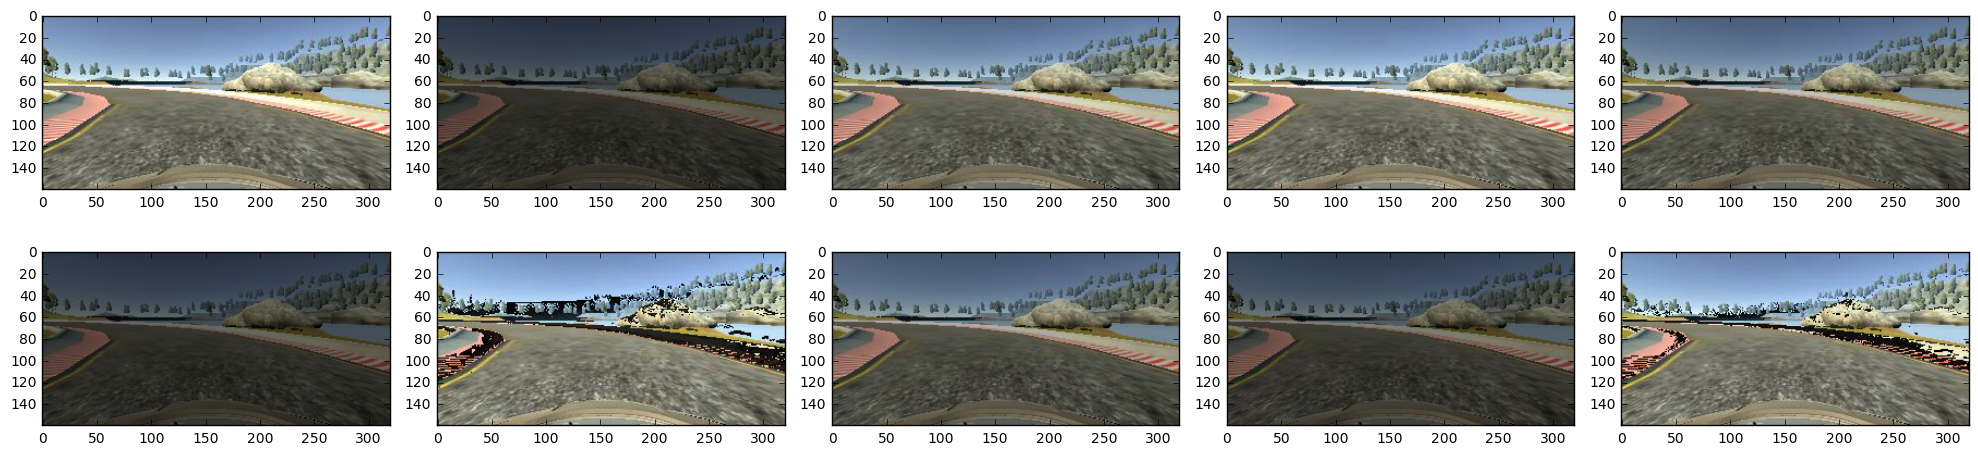

In [34]:
# Check change_brightness function

center_image = plt.imread(X_train_data["center_image"][0])
angle = X_train_data["steering_angle"][0]

print ("angle:", angle)

plt.rcParams["figure.figsize"] = [20, 5]
for i in range(0, 10):
    plt.subplot(2, 5, i+1) 
    plt.tight_layout()
    if i == 0:
        plt.imshow(center_image) 
    else:
        plt.imshow(change_brightness(center_image))
    

In [35]:
def preprocessImage(image):
    # Proportionally get lower half portion of the image
    nrow, ncol, nchannel = image.shape
    
    start_row = int(nrow * 0.35)
    end_row = int(nrow * 0.875)   
    
    # This removes most of the sky and small amount below including the hood
    new_image = image[start_row:end_row, :]
    
    # This resizes to 66 x 220 for NVIDIA's model
    new_image = cv2.resize(new_image, (220,66), interpolation=cv2.INTER_AREA)
    
    return new_image
    

center_image:  (160, 320, 3)
resize_img:  (66, 220, 3)


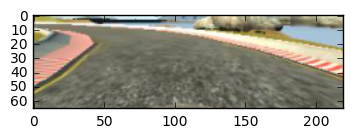

In [36]:
# Check preprocessImage function (includes resizing to 66 x 220)
print ("center_image: ", center_image.shape)
resize_img = preprocessImage(center_image)
print ("resize_img: ", resize_img.shape)

plt.figure(figsize=(4,3))
plt.imshow(resize_img)

In [38]:
def preprocess_image_train(data_row_df):

    path_filename = data_row_df["center_image"][0]
    image = cv2.imread(path_filename)
    angle = data_row_df['steering_angle'][0]
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
    image = change_brightness(image)
    
    # Coin flip to see to flip image and create a new sample of -angle
    if np.random.randint(2) == 1:
        image, angle = flip_image(image, angle)
    
    image = preprocessImage(image)
    image = np.array(image)

    return image, angle

def preprocess_image_valid(data_row_df):

    path_filename = data_row_df["center_image"][0]
    angle = data_row_df['steering_angle'][0]
    image = cv2.imread(path_filename)
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    # Note: drive.py needs to run preprocessImage() when running the simulator
    image = preprocessImage(image)
    image = np.array(image)
    
    return image, angle
    

angle: -0.175991986215


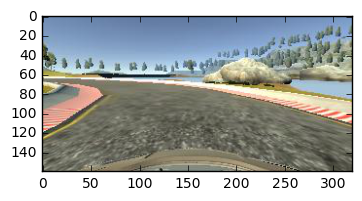

In [39]:
tst = X_train_data.iloc[[0]]
tst_path = tst["center_image"][0]
tst_angle = tst["steering_angle"][0]

this_image = cv2.imread(tst_path)
this_image = cv2.cvtColor(this_image,cv2.COLOR_BGR2RGB)

print("angle:", angle)

plt.figure(figsize=(4,3))
plt.imshow(this_image)

this_y: -0.175991986215 shape: (66, 220, 3)


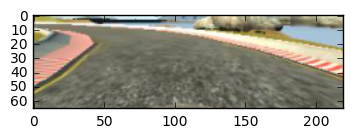

In [41]:
this_image, this_y = preprocess_image_valid(this_data)
print ("this_y:", this_y, "shape:", this_image.shape)

plt.figure(figsize=(4,3))
plt.imshow(this_image)

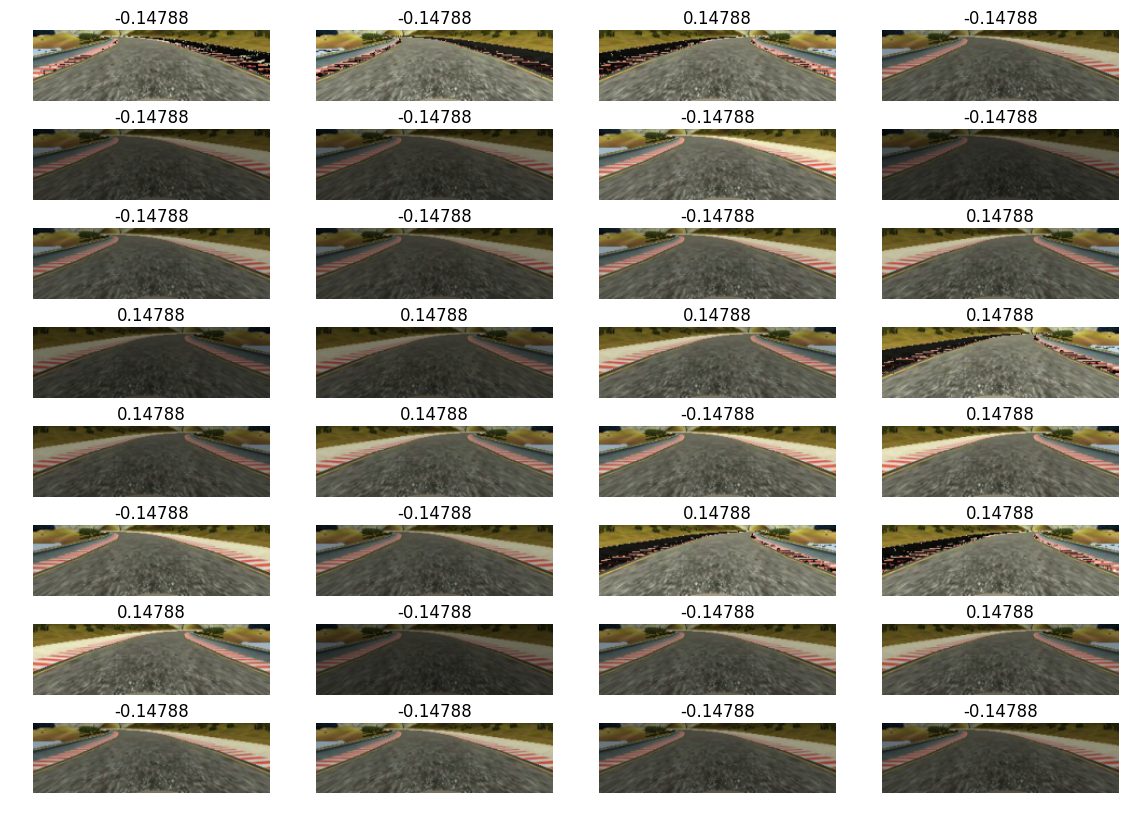

In [44]:
# Check preprocess_image_train function
data_row = df.iloc[[275]].reset_index()

plt.figure(figsize=(14, 10))
for i in range(32):
    image, angle = preprocess_image_train(data_row)

    plt.subplot(8,4,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(angle,5)))

In [45]:
# NVIDIA's input parameters
INPUT_IMG_HEIGHT = 66
INPUT_IMG_WIDTH = 220

# This will generate a batch of new images of final input dimensions 
# and the y output (steering_angles)
def generate_batch_train_from_dataframe(data_df, batch_size = 128):
    
    batch_images = np.zeros((batch_size, INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3))
    batch_angles = np.zeros(batch_size)
    
    while True:
        for i in range (batch_size):
            # Randomly get a sample from the input data
            idx = np.random.randint(len(data_df))

            # reset_index sets this df starting row to 0
            data_row = data_df.iloc[[idx]].reset_index()
            img1, angle1 = preprocess_image_train(data_row)

            batch_images[i] = img1
            batch_angles[i] = angle1

        yield batch_images, batch_angles
    
def generate_valid_from_dataframe(data_df):
    while True:
        for idx in range(len(data_df)):
            data_row = data_df.iloc[[idx]].reset_index()
            img, angle = preprocess_image_valid(data_row)
            # Since not stacking the images, it's shape remains (height, width, channel)
            # but need it to be (1, height, width, channel)
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle

In [46]:
# Initialize generator
valid_data_generator = generate_valid_from_dataframe(X_valid_data)

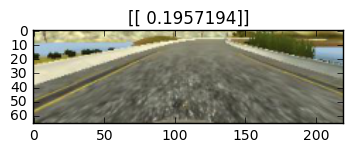

In [47]:
# Testing the generator
for i in range(100):
    next(valid_data_generator)

plt.figure(figsize=(4, 3))    
img, angle = next(valid_data_generator)
plt.imshow(img[0])
plt.title(str(angle))

In [48]:
from pathlib import Path

def save_model(fileModelJSON, fileWeights):
    prefix = "model/"
    
    filenameJSON = prefix + fileModelJSON
    if Path(filenameJSON).is_file():
        os.remove(filenameJSON)    
    with open (filenameJSON, 'w') as outfile:
        json.dump(model.to_json(), outfile)
        
    filenameWeights = prefix + fileWeights
    if Path(filenameWeights).is_file():
        os.remove(filenameWeights)
    model.save_weights(filenameWeights, True)

In [49]:
print("img_height:", IMG_HEIGHT)
print("img_width:", IMG_WIDTH)
print("img_channel:", IMG_CHANNEL)
print("len(X_train_data:)", len(X_train_data))
print("len(X_valid_data:)", len(X_valid_data))

img_height: 160
img_width: 320
img_channel: 3
len(X_train_data:) 17272
len(X_valid_data:) 4318


In [50]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

# This is the image size after processing
input_shape = (INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3)

nb_train_samples = len(X_train_data)
nb_validation_samples = len(X_valid_data)
nb_epoch = 6

In [51]:
# Basic model from Keras tutorial: https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d

def get_model_keras_tutorial():
    
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=input_shape))

    model.add(Convolution2D(32, 3, 3, input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(32, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, 3, 3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    #model.add(Activation('sigmoid'))
    #adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    adam = Adam()

    model.compile(optimizer=adam, loss='mse')
    
    return model

In [52]:
# Comma.ai model https://github.com/commaai/research/blob/master/train_steering_model.py
 
def get_model_comma_ai():
    #ch, row, col = 3, 160, 320  # camera format

    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
        input_shape=input_shape,
        output_shape=input_shape))

    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))

    model.compile(optimizer="adam", loss="mse")

    return model

In [53]:
# NVIDIA https://arxiv.org/pdf/1604.07316v1.pdf

def get_model_nvidia():
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv1'))
    model.add(ELU())
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv2'))
    model.add(ELU())
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv3'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv4'))
    model.add(ELU())
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv5'))
    model.add(Flatten(name='flatten1'))
    model.add(ELU())
    model.add(Dense(1164, init='he_normal', name='dense1'))
    model.add(ELU())
    model.add(Dense(100, init='he_normal', name='dense2'))
    model.add(ELU())
    model.add(Dense(50, init='he_normal', name='dense3'))
    model.add(ELU())
    model.add(Dense(10, init='he_normal', name='dense4'))
    model.add(ELU())
    model.add(Dense(1, init='he_normal', name='dense5'))

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')
    
    return model

In [55]:
val_size = len(X_valid_data)
batch_size = 256

idx_best = 0
val_best = 9999

for idx in range(3):
    print(">>> Iteration :", idx, " <<<")    
    train_data_generator = generate_batch_train_from_dataframe(X_train_data, batch_size)
    
    #model = get_model_keras_tutorial()
    #model = get_model_comma_ai()
    model = get_model_nvidia()
    history = model.fit_generator(train_data_generator, samples_per_epoch=2048,
                                 nb_epoch=2, validation_data=valid_data_generator,
                                 nb_val_samples=val_size)
    
    fileModelJSON = 'model_nvidia' + str(idx) + '.json'
    fileWeights = 'model_nvidia' + str(idx) + '.h5'
    save_model(fileModelJSON, fileWeights)
    
    val_loss = history.history['val_loss'][0]
    
    # If found a small val_loss then that's the new val_best
    if val_loss < val_best:
        val_best = val_loss
        idx_best = idx

print("Best model found at idx:", idx_best)
print("Best Validation score:", val_best)


>>> Iteration : 0  <<<
Epoch 1/2
2048/2048 [==============================] - 32s - loss: 0.1691 - val_loss: 0.0635
Epoch 2/2
2048/2048 [==============================] - 30s - loss: 0.0781 - val_loss: 0.0636